# Problem Statement & Description
Customers looking to buy a new car expect an optimum ROI depending upon their price range. However, the sheer variety of cars with differentiated capabilities and features such as model, make, mileage, production year, category, fuel type, engine volume, colour, and accessories, makes it challenging for buyers to make an informed decision. To that end, MachineHack, in association with TheMathCompany, calls the data science community to develop a machine learning model for forecasting the price of a car within a budget with the best features available.

The objective of this assignment is to use historical car pricing data to forecast the price of a car within the user's budget. This is a standard supervised Multiple Linear Regression / Multivariate Linear Regression task:

**Supervised**: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features.

**Multiple linear regression**: The target label here is a continuous variable, and our attempt is to model the relationship between two or more features and a response by fitting a linear equation to the observed data.

## Step 1. Importing the necessary libraries / dependencies.

In [970]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import RandomizedSearchCV



import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,6)


# Step 2. Loading the dataset

In [971]:
url = "/content/MathCo_Hackathon/train.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [972]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,ID,Price,Prod. year,Cylinders,Airbags
count,19237.00000,19237.00000,19237.00000,19237.00000,19237.00000
mean,45576535.88610,18555.92722,2010.91282,4.58299,6.58263
std,936591.42280,190581.26968,5.66867,1.19993,4.32017
min,20746880.00000,1.00000,1939.00000,1.00000,0.00000
25%,45698374.00000,5331.00000,2009.00000,4.00000,4.00000
50%,45772308.00000,13172.00000,2012.00000,4.00000,6.00000
75%,45802036.00000,22075.00000,2015.00000,4.00000,12.00000
max,45816654.00000,26307500.00000,2020.00000,16.00000,16.00000


From the info() and describe() function results, we can understand the following:
1. **There are no null values.**
2. **Some features are of different dtypes than what we want.**
3. **Prod. year can be changed to 'No. of years' later to determine the age of the car.**

That's a good start. Now, Let us have a look at the DataFrame.

In [973]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


From the above table, it is clear that **Levy contains a lot of hyphon (-) values instead of NaN**. 

Let us first remove the 'ID' and 'Levy' features.

Then, we shall focus on the following :
* **duplicate entries**
* **converting all strings to lowercase.**
* **Removing the "km" from Mileage entries and converting them to int type.**
* **Editing out the 'Doors' feature as well. It is given as some dates.**

# Step 3. Pre-Processing the data along with EDA

In [974]:
df.drop(['ID','Levy'],axis=1, inplace=True)     # Dropping 'ID' and 'Levy' features

df = df.applymap(lambda s:s.lower() if type(s) == str else s)   # Converting everything to lowercase

df = df.drop_duplicates()                       # Removing duplicate rows

df['Mileage'] = df.Mileage.str.split(expand=True) 
df['Mileage'] = df['Mileage'].astype(str).astype(int)   # Splitting the 'km' string from Mileage and converting it to int type

df.replace(to_replace=['02-mar','04-may'],value={'2','4'},inplace=True) # Converting the date strings to actual door counts

df['Current Year'] = 2021                                  # Creating a new feature 'no. of years' and dropping 'Prod. year' feature. 
df['no. of years'] = df['Current Year'] - df['Prod. year']
df.drop(labels=['Prod. year','Current Year'],axis=1,inplace=True)

df.head(10)

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years
0,13328,lexus,rx 450,jeep,yes,hybrid,3.5,186005,6.0,automatic,4x4,2,left wheel,silver,12,11
1,16621,chevrolet,equinox,jeep,no,petrol,3,192000,6.0,tiptronic,4x4,2,left wheel,black,8,10
2,8467,honda,fit,hatchback,no,petrol,1.3,200000,4.0,variator,front,2,right-hand drive,black,2,15
3,3607,ford,escape,jeep,yes,hybrid,2.5,168966,4.0,automatic,4x4,2,left wheel,white,0,10
4,11726,honda,fit,hatchback,yes,petrol,1.3,91901,4.0,automatic,front,2,left wheel,silver,4,7
5,39493,hyundai,santa fe,jeep,yes,diesel,2,160931,4.0,automatic,front,2,left wheel,white,4,5
6,1803,toyota,prius,hatchback,yes,hybrid,1.8,258909,4.0,automatic,front,2,left wheel,white,12,11
7,549,hyundai,sonata,sedan,yes,petrol,2.4,216118,4.0,automatic,front,2,left wheel,grey,12,8
8,1098,toyota,camry,sedan,yes,hybrid,2.5,398069,4.0,automatic,front,2,left wheel,black,12,7
9,26657,lexus,rx 350,jeep,yes,petrol,3.5,128500,6.0,automatic,4x4,2,left wheel,silver,12,14


Looks good so far. Now let us dig deep and see if there any more pre-processing to be done.

**Note** : Cylinders can be converted to int type.

In [975]:
# Let us now check how many and what n all unique values each of these features have :
print(df['Engine volume'].unique())
print("\n",df['Category'].unique())
print("\n", df['Leather interior'].unique())
print("\n", df['Fuel type'].unique())
print("\n", df['Gear box type'].unique())
print("\n", df['Drive wheels'].unique())
print("\n", df['Wheel'].unique())
print("\n", df['Color'].unique())

['3.5' '3' '1.3' '2.5' '2' '1.8' '2.4' '4' '1.6' '3.3' '2.0 turbo'
 '2.2 turbo' '4.7' '1.5' '4.4' '3.0 turbo' '1.4 turbo' '3.6' '2.3'
 '1.5 turbo' '1.6 turbo' '2.2' '2.3 turbo' '1.4' '5.5' '2.8 turbo' '3.2'
 '3.8' '4.6' '1.2' '5' '1.7' '2.9' '0.5' '1.8 turbo' '2.4 turbo'
 '3.5 turbo' '1.9' '2.7' '4.8' '5.3' '0.4' '2.8' '3.2 turbo' '1.1' '2.1'
 '0.7' '5.4' '1.3 turbo' '3.7' '1' '2.5 turbo' '2.6' '1.9 turbo'
 '4.4 turbo' '4.7 turbo' '0.8' '0.2 turbo' '5.7' '4.8 turbo' '4.6 turbo'
 '6.7' '6.2' '1.2 turbo' '3.4' '1.7 turbo' '6.3 turbo' '2.7 turbo' '4.3'
 '4.2' '2.9 turbo' '0' '4.0 turbo' '20' '3.6 turbo' '0.3' '3.7 turbo'
 '5.9' '5.5 turbo' '0.2' '2.1 turbo' '5.6' '6' '0.7 turbo' '0.6 turbo'
 '6.8' '4.5' '0.6' '7.3' '0.1' '1.0 turbo' '6.3' '4.5 turbo' '0.8 turbo'
 '4.2 turbo' '3.1' '5.0 turbo' '6.4' '3.9' '5.7 turbo' '0.9' '0.4 turbo'
 '5.4 turbo' '0.3 turbo' '5.2' '5.8' '1.1 turbo']

 ['jeep' 'hatchback' 'sedan' 'microbus' 'goods wagon' 'universal' 'coupe'
 'minivan' 'cabriolet' 'limousin

So, 'Engine volume' also has strings attached to it. Since Turbo engines are much more efficient, they are important for our analysis. So, let us split them and create a feature 'Turbo' which gives 1 if Turbo is present and 0 otherwise.

In [976]:
df[['Engine volume', 'Turbo']] = df['Engine volume'].str.split(expand=True)
df['Engine volume'] = df['Engine volume'].astype(float)

df.replace(to_replace='turbo',value='1',inplace=True)
df['Turbo'] = df['Turbo'].fillna(0)

df['Cylinders'] = df['Cylinders'].astype(int)


df.head(15)

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years,Turbo
0,13328,lexus,rx 450,jeep,yes,hybrid,3.5,186005,6,automatic,4x4,2,left wheel,silver,12,11,0
1,16621,chevrolet,equinox,jeep,no,petrol,3.0,192000,6,tiptronic,4x4,2,left wheel,black,8,10,0
2,8467,honda,fit,hatchback,no,petrol,1.3,200000,4,variator,front,2,right-hand drive,black,2,15,0
3,3607,ford,escape,jeep,yes,hybrid,2.5,168966,4,automatic,4x4,2,left wheel,white,0,10,0
4,11726,honda,fit,hatchback,yes,petrol,1.3,91901,4,automatic,front,2,left wheel,silver,4,7,0
5,39493,hyundai,santa fe,jeep,yes,diesel,2.0,160931,4,automatic,front,2,left wheel,white,4,5,0
6,1803,toyota,prius,hatchback,yes,hybrid,1.8,258909,4,automatic,front,2,left wheel,white,12,11,0
7,549,hyundai,sonata,sedan,yes,petrol,2.4,216118,4,automatic,front,2,left wheel,grey,12,8,0
8,1098,toyota,camry,sedan,yes,hybrid,2.5,398069,4,automatic,front,2,left wheel,black,12,7,0
9,26657,lexus,rx 350,jeep,yes,petrol,3.5,128500,6,automatic,4x4,2,left wheel,silver,12,14,0


In [977]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Price,Engine volume,Mileage,Cylinders,Airbags,no. of years
count,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000
mean,20279.43936,2.21282,1836420.68687,4.48356,6.54334,10.48108
std,210639.02232,0.80619,53532475.32326,1.13447,4.06773,6.01212
min,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000
25%,7527.00000,1.70000,66575.00000,4.00000,4.00000,7.00000
50%,14166.00000,2.00000,121000.00000,4.00000,6.00000,9.00000
75%,23364.00000,2.50000,180000.00000,4.00000,12.00000,13.00000
max,26307500.00000,20.00000,2147483647.00000,16.00000,16.00000,82.00000


Here, we can see that 'Engine volume' feature has a max value of 20 and a min value of 0. 'Mileage' feature has a max value of 2147483647 and min value of 0. These are clearly outliers. We need to investigate more on them. Practically, an odometer resets after crossing 999,999.

Similarly, Airbags greater than 10 and Cylinders above 8 are rare.

So, let us now check out these outliers.

In [978]:
df[df['Engine volume']==20]

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years,Turbo
2357,10036,hyundai,sonata,sedan,yes,lpg,20.0,333686,4,automatic,front,2,left wheel,silver,4,7,0


In [979]:
df[df['Cylinders'] == 16]

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years,Turbo
456,11604,opel,astra,goods wagon,no,diesel,1.3,27000,16,manual,front,2,left wheel,black,8,15,1
1917,7000,honda,fit aria,hatchback,no,petrol,1.5,140203,16,automatic,front,2,right-hand drive,silver,2,18,1
6863,21953,hyundai,elantra,sedan,yes,petrol,1.8,69000,16,automatic,front,2,left wheel,silver,16,5,0
12550,39829,bmw,x6,jeep,yes,petrol,3.5,152000,16,tiptronic,4x4,2,left wheel,grey,16,12,1
16487,7213,opel,combo,goods wagon,no,diesel,1.7,242701,16,manual,front,4,left wheel,blue,2,20,1


In [980]:
df[df['Mileage'] == 0]

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years,Turbo
11,8781,ford,transit,microbus,no,cng,4.0,0,8,manual,rear,4,left wheel,blue,0,22,0
24,4704,opel,vectra,sedan,no,petrol,1.8,0,4,automatic,front,2,left wheel,green,4,26,0
26,549,lexus,gx 470,jeep,yes,petrol,4.7,0,8,automatic,4x4,2,left wheel,white,0,13,0
83,8154,honda,cr-v,jeep,no,petrol,2.0,0,4,automatic,4x4,2,right-hand drive,white,2,23,0
97,4234,honda,civic,hatchback,yes,petrol,1.4,0,4,manual,front,4,left wheel,blue,6,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19047,941,toyota,prius,hatchback,yes,hybrid,1.8,0,4,automatic,front,2,left wheel,grey,12,7,0
19064,2900,bmw,320,sedan,yes,petrol,2.0,0,6,manual,rear,2,left wheel,green,2,27,0
19088,2200,peugeot,406,sedan,no,petrol,2.0,0,4,manual,front,2,left wheel,white,2,20,0
19218,30,nissan,note,hatchback,no,petrol,1.3,0,4,automatic,front,2,right-hand drive,green,9,15,0


In [981]:
df[df['Mileage'] > 999999]

,Price,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years,Turbo
144,4300,mercedes-benz,208,universal,no,diesel,2.5,1111111,4,manual,rear,2,left wheel,black,1,36,0
493,15994,toyota,camry,sedan,no,petrol,2.5,1440000,4,automatic,front,2,left wheel,silver,0,7,0
985,2700,opel,vectra,sedan,no,cng,1.6,777777777,4,automatic,front,2,left wheel,beige,2,24,0
1146,13485,bmw,525,sedan,yes,petrol,2.5,7777787,6,manual,rear,2,left wheel,silver,10,18,0
1404,9095,bmw,328,sedan,no,petrol,2.8,55556665,6,manual,rear,2,left wheel,silver,6,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18673,40,honda,fit,hatchback,yes,petrol,1.6,15000000,7,automatic,front,2,left wheel,sky blue,9,14,0
18846,14113,toyota,prius,hatchback,yes,hybrid,1.5,2696320,4,automatic,front,2,left wheel,grey,6,16,0
18950,3607,volkswagen,jetta,sedan,no,cng,2.0,3000000,4,manual,front,2,left wheel,black,2,22,0
19167,18817,ford,transit,microbus,no,diesel,2.4,2147483647,4,manual,front,4,left wheel,white,2,18,1


Category,	Leather interior,	Fuel type, Gear box type,	Drive wheels,	Doors, Wheel, and Color must be converted to type '**Category**' and Turbo to **int**.

In [982]:
df['Category'] = df['Category'].astype('category')
df['Leather interior'] = df['Leather interior'].astype('category')
df['Fuel type'] = df['Fuel type'].astype('category')
df['Gear box type'] = df['Gear box type'].astype('category')
df['Drive wheels'] = df['Drive wheels'].astype('category')
df['Wheel'] = df['Wheel'].astype('category')
df['Color'] = df['Color'].astype('category')
df['Turbo'] = df['Turbo'].astype(str).astype(int)
df['Doors'] = df['Doors'].astype('category')

In [983]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15725 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Price             15725 non-null  int64   
 1   Manufacturer      15725 non-null  object  
 2   Model             15725 non-null  object  
 3   Category          15725 non-null  category
 4   Leather interior  15725 non-null  category
 5   Fuel type         15725 non-null  category
 6   Engine volume     15725 non-null  float64 
 7   Mileage           15725 non-null  int64   
 8   Cylinders         15725 non-null  int64   
 9   Gear box type     15725 non-null  category
 10  Drive wheels      15725 non-null  category
 11  Doors             15725 non-null  category
 12  Wheel             15725 non-null  category
 13  Color             15725 non-null  category
 14  Airbags           15725 non-null  int64   
 15  no. of years      15725 non-null  int64   
 16  Turbo             1572

Let us also remove the 2 object type features from our dataframe for the time bring.

In [984]:
df_final = df.drop(labels=['Manufacturer',	'Model'],axis=1)
df_final.head()


,Price,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,no. of years,Turbo
0,13328,jeep,yes,hybrid,3.5,186005,6,automatic,4x4,2,left wheel,silver,12,11,0
1,16621,jeep,no,petrol,3.0,192000,6,tiptronic,4x4,2,left wheel,black,8,10,0
2,8467,hatchback,no,petrol,1.3,200000,4,variator,front,2,right-hand drive,black,2,15,0
3,3607,jeep,yes,hybrid,2.5,168966,4,automatic,4x4,2,left wheel,white,0,10,0
4,11726,hatchback,yes,petrol,1.3,91901,4,automatic,front,2,left wheel,silver,4,7,0


**Looks good!! Now that we have moulded the dataframe to meet our specifications, let us now prepare it to be fed into a Regression model.**

## Going to use get_dummies() for categorical values

In [985]:
categorical = ['Category', 'Leather interior',	'Fuel type',	'Gear box type',	'Drive wheels',	'Doors', 'Wheel',	'Color']

In [986]:
#Extract only the columns that didnt need to be encoded
df_other_cols = df_final.drop(columns=categorical)

#Concatenate the two dataframes : 
df_out = pd.concat([df_other_cols, pd.get_dummies(df_final[categorical])], axis=1)


In [987]:
df_out.shape

(15725, 55)

In [988]:
df_out.describe().apply(lambda s: s.apply('{0:.5f}'.format)) # It is good to keep track of the statistical structure of the dataframe.

,Price,Engine volume,Mileage,Cylinders,Airbags,no. of years,Turbo,Category_cabriolet,Category_coupe,Category_goods wagon,Category_hatchback,Category_jeep,Category_limousine,Category_microbus,Category_minivan,Category_pickup,Category_sedan,Category_universal,Leather interior_no,Leather interior_yes,Fuel type_cng,Fuel type_diesel,Fuel type_hybrid,Fuel type_hydrogen,Fuel type_lpg,Fuel type_petrol,Fuel type_plug-in hybrid,Gear box type_automatic,Gear box type_manual,Gear box type_tiptronic,Gear box type_variator,Drive wheels_4x4,Drive wheels_front,Drive wheels_rear,Doors_2,Doors_4,Doors_>5,Wheel_left wheel,Wheel_right-hand drive,Color_beige,Color_black,Color_blue,Color_brown,Color_carnelian red,Color_golden,Color_green,Color_grey,Color_orange,Color_pink,Color_purple,Color_red,Color_silver,Color_sky blue,Color_white,Color_yellow
count,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000,15725.00000
mean,20279.43936,2.21282,1836420.68687,4.48356,6.54334,10.48108,0.12013,0.00223,0.03027,0.01456,0.16203,0.26868,0.00070,0.01876,0.03396,0.00324,0.44579,0.01978,0.32859,0.67141,0.02976,0.20407,0.15415,0.00006,0.04541,0.56114,0.00541,0.64153,0.11707,0.19485,0.04655,0.17590,0.69889,0.12521,0.94467,0.04744,0.00789,0.90893,0.09107,0.00852,0.24388,0.07930,0.01094,0.01126,0.00903,0.01831,0.12203,0.01297,0.00159,0.00248,0.03606,0.20025,0.00776,0.22963,0.00598
std,210639.02232,0.80619,53532475.32326,1.13447,4.06773,6.01212,0.32512,0.04713,0.17134,0.11980,0.36849,0.44329,0.02644,0.13568,0.18113,0.05686,0.49707,0.13924,0.46971,0.46971,0.16993,0.40303,0.36110,0.00797,0.20820,0.49626,0.07332,0.47957,0.32152,0.39610,0.21068,0.38075,0.45876,0.33097,0.22862,0.21259,0.08845,0.28771,0.28771,0.09192,0.42943,0.27022,0.10401,0.10550,0.09460,0.13409,0.32734,0.11316,0.03984,0.04974,0.18644,0.40020,0.08774,0.42061,0.07709
min,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,7527.00000,1.70000,66575.00000,4.00000,4.00000,7.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,14166.00000,2.00000,121000.00000,4.00000,6.00000,9.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,23364.00000,2.50000,180000.00000,4.00000,12.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


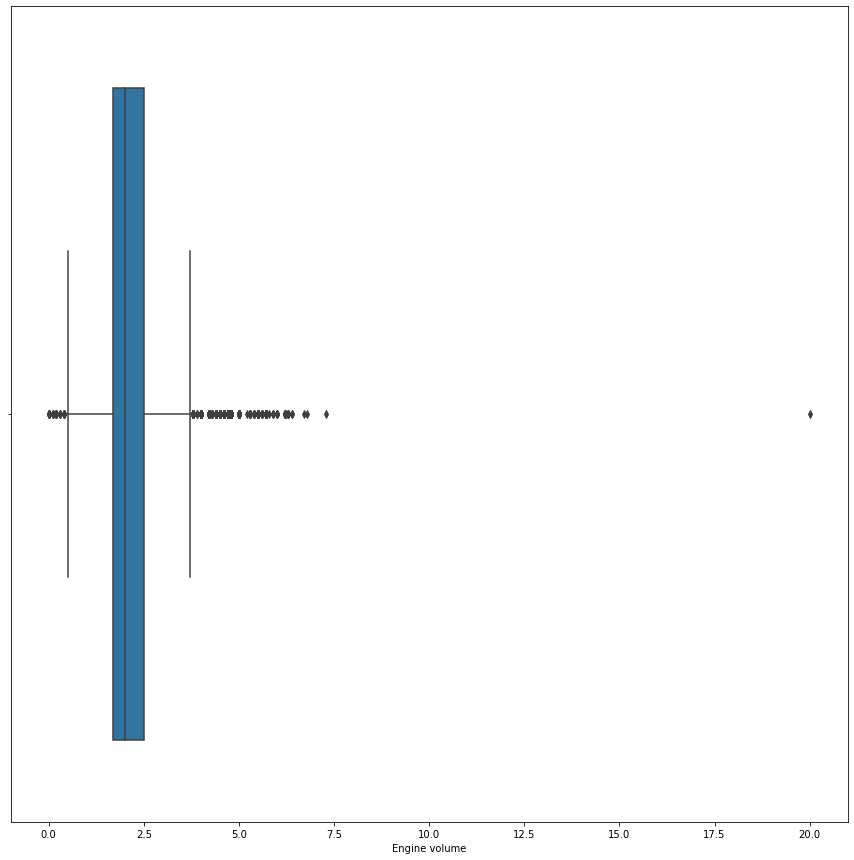

In [989]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches    
sns.boxplot(df_out['Engine volume'])
#sns.boxplot(df_out['Cylinders'])
plt.show()

**With the following conditions, we'd be able to handle outliers to a good extent :**

In [990]:
df_out.loc[df_out['Engine volume'] > 8.4, 'Engine volume'] = df_out['Engine volume'].median()  
df_out.loc[df_out['Engine volume'] < 1.2, 'Engine volume'] = df_out['Engine volume'].median()

df_out.loc[df_out['Mileage'] == 0, 'Mileage'] = df_out['Mileage'].median()
df_out.loc[df_out['Mileage'] > 999999, 'Mileage'] = df_out['Mileage'].median()

df_out.loc[df_out['Cylinders'] > 8, 'Cylinders'] = df_out['Cylinders'].median()
df_out.loc[df_out['Cylinders'] < 1, 'Cylinders'] = df_out['Cylinders'].median()

df_out.loc[df_out['Airbags'] > 10, 'Airbags'] = df_out['Airbags'].median()

df_out = df_out.loc[df_out['Price'] < np.percentile(df_out.Price,99.995)]
df_out = df_out.loc[df_out['Price'] > np.percentile(df_out.Price,6)]


In [991]:
df_out.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Price,Engine volume,Mileage,Cylinders,Airbags,no. of years,Turbo,Category_cabriolet,Category_coupe,Category_goods wagon,Category_hatchback,Category_jeep,Category_limousine,Category_microbus,Category_minivan,Category_pickup,Category_sedan,Category_universal,Leather interior_no,Leather interior_yes,Fuel type_cng,Fuel type_diesel,Fuel type_hybrid,Fuel type_hydrogen,Fuel type_lpg,Fuel type_petrol,Fuel type_plug-in hybrid,Gear box type_automatic,Gear box type_manual,Gear box type_tiptronic,Gear box type_variator,Drive wheels_4x4,Drive wheels_front,Drive wheels_rear,Doors_2,Doors_4,Doors_>5,Wheel_left wheel,Wheel_right-hand drive,Color_beige,Color_black,Color_blue,Color_brown,Color_carnelian red,Color_golden,Color_green,Color_grey,Color_orange,Color_pink,Color_purple,Color_red,Color_silver,Color_sky blue,Color_white,Color_yellow
count,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000,14676.00000
mean,19917.42552,2.21928,137101.03005,4.44038,4.95319,10.53380,0.12633,0.00225,0.03107,0.01533,0.15767,0.26969,0.00041,0.01942,0.03489,0.00320,0.44488,0.02119,0.33613,0.66387,0.03134,0.21355,0.14541,0.00007,0.04749,0.55635,0.00579,0.62551,0.12285,0.20407,0.04756,0.17028,0.70278,0.12694,0.94290,0.04926,0.00784,0.91087,0.08913,0.00872,0.24244,0.07911,0.01070,0.01158,0.00947,0.01881,0.12197,0.01376,0.00157,0.00252,0.03570,0.20285,0.00790,0.22649,0.00641
std,20579.80597,0.76785,95343.47977,1.02709,2.42428,5.96480,0.33223,0.04737,0.17352,0.12287,0.36445,0.44381,0.02022,0.13800,0.18350,0.05650,0.49697,0.14403,0.47240,0.47240,0.17425,0.40982,0.35252,0.00825,0.21270,0.49683,0.07589,0.48401,0.32828,0.40304,0.21284,0.37589,0.45705,0.33292,0.23204,0.21643,0.08818,0.28493,0.28493,0.09299,0.42857,0.26992,0.10288,0.10701,0.09686,0.13584,0.32726,0.11651,0.03956,0.05015,0.18556,0.40213,0.08856,0.41858,0.07978
min,600.00000,1.20000,13.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,8781.00000,1.80000,74581.50000,4.00000,4.00000,7.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,15383.50000,2.00000,121000.00000,4.00000,4.00000,9.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,24148.00000,2.50000,177792.50000,4.00000,6.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.

Now, let us check the correlation between our features. I am using a Heatmap here.

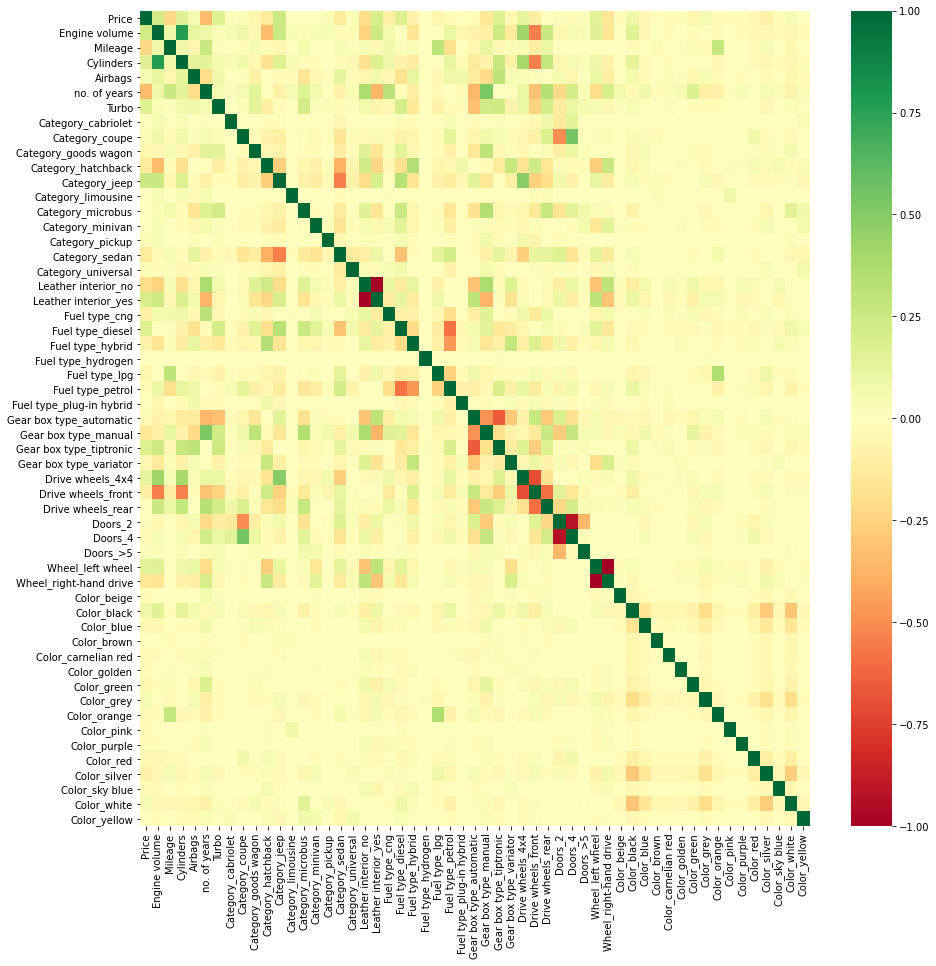

In [992]:
#import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(df_out.corr(), annot = False, vmin=-1, vmax=1, center= 0,cmap="RdYlGn")

We can see that there some good correlation among some features. Let us find out how much it would help us with our model.

## Time for our X and Y datasets.

In [993]:
X = df_out.iloc[:,1:]
y = df_out.iloc[:,0]

In [994]:
X.head()

,Engine volume,Mileage,Cylinders,Airbags,no. of years,Turbo,Category_cabriolet,Category_coupe,Category_goods wagon,Category_hatchback,Category_jeep,Category_limousine,Category_microbus,Category_minivan,Category_pickup,Category_sedan,Category_universal,Leather interior_no,Leather interior_yes,Fuel type_cng,Fuel type_diesel,Fuel type_hybrid,Fuel type_hydrogen,Fuel type_lpg,Fuel type_petrol,Fuel type_plug-in hybrid,Gear box type_automatic,Gear box type_manual,Gear box type_tiptronic,Gear box type_variator,Drive wheels_4x4,Drive wheels_front,Drive wheels_rear,Doors_2,Doors_4,Doors_>5,Wheel_left wheel,Wheel_right-hand drive,Color_beige,Color_black,Color_blue,Color_brown,Color_carnelian red,Color_golden,Color_green,Color_grey,Color_orange,Color_pink,Color_purple,Color_red,Color_silver,Color_sky blue,Color_white,Color_yellow
0,3.5,186005.0,6.0,6.0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,3.0,192000.0,6.0,8.0,10,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.3,200000.0,4.0,2.0,15,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.5,168966.0,4.0,0.0,10,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1.3,91901.0,4.0,4.0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [995]:
y.head()

0    13328
1    16621
2     8467
3     3607
4    11726
Name: Price, dtype: int64

## Let us now check for important features in our dataset.

In [996]:
##### Feature Importance

model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

Feature: 0, Score: 0.14
Feature: 1, Score: 0.08
Feature: 2, Score: 0.06
Feature: 3, Score: 0.06
Feature: 4, Score: 0.24
Feature: 5, Score: 0.05
Feature: 6, Score: 0.00
Feature: 7, Score: 0.01
Feature: 8, Score: 0.00
Feature: 9, Score: 0.00
Feature: 10, Score: 0.06
Feature: 11, Score: 0.00
Feature: 12, Score: 0.00
Feature: 13, Score: 0.00
Feature: 14, Score: 0.00
Feature: 15, Score: 0.01
Feature: 16, Score: 0.03
Feature: 17, Score: 0.01
Feature: 18, Score: 0.01
Feature: 19, Score: 0.00
Feature: 20, Score: 0.02
Feature: 21, Score: 0.00
Feature: 22, Score: 0.00
Feature: 23, Score: 0.00
Feature: 24, Score: 0.01
Feature: 25, Score: 0.00
Feature: 26, Score: 0.02
Feature: 27, Score: 0.00
Feature: 28, Score: 0.04
Feature: 29, Score: 0.00
Feature: 30, Score: 0.01
Feature: 31, Score: 0.02
Feature: 32, Score: 0.00
Feature: 33, Score: 0.00
Feature: 34, Score: 0.01
Feature: 35, Score: 0.00
Feature: 36, Score: 0.00
Feature: 37, Score: 0.00
Feature: 38, Score: 0.00
Feature: 39, Score: 0.04
Feature: 4

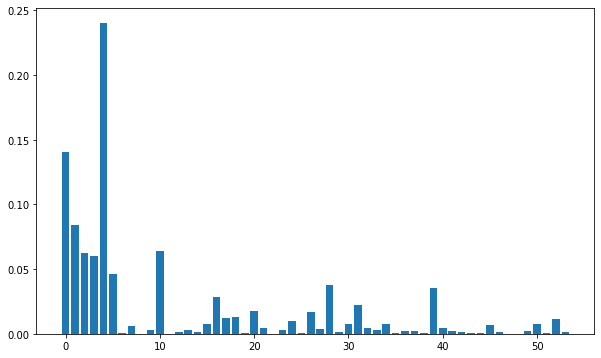

In [997]:
result = model.feature_importances_
for i,v in enumerate(result):
	print('Feature: %0d, Score: %.2f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(result))], result)
plt.show()

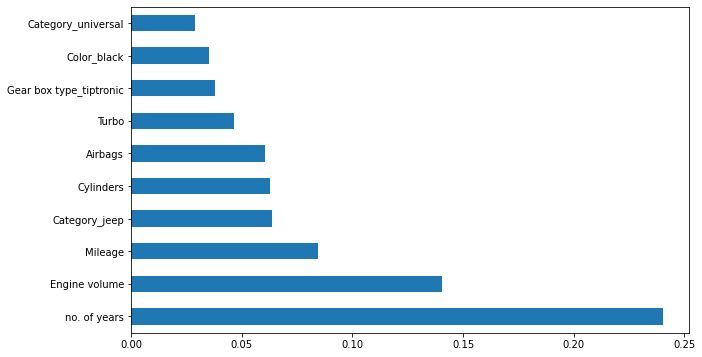

In [998]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

These are the important features in our dataset. I am anyways going to include all the features for train_test_split. 

# Step 4. Splitting the data after pre-processing

In [999]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [1000]:
X_train.shape

(10273, 54)

# Step 5. Using RandomizedSearchCV to fit and score our Random Forest Regressor Model.

In [1001]:
## Hyperparameters

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [1002]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [1003]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [1004]:
rf = RandomForestRegressor()

In [1005]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_log_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [1006]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   5.1s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   4.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   4.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   4.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   4.7s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   7.7s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [1007]:
rf_random.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 700}

In [1008]:
rf_random.best_score_

-0.40747366333971957

# Step 6. Make Predictions for X_test and verify the results



In [1009]:
predictions=rf_random.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


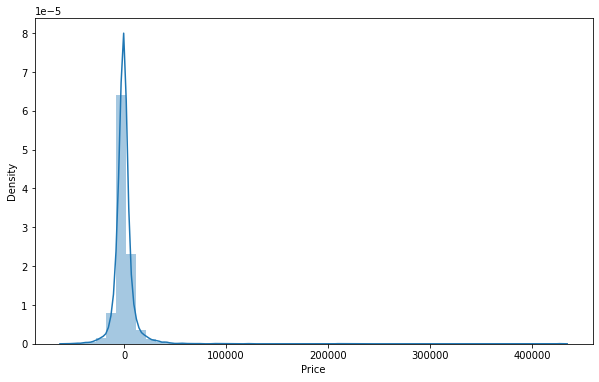

In [1010]:
sns.distplot(y_test-predictions)

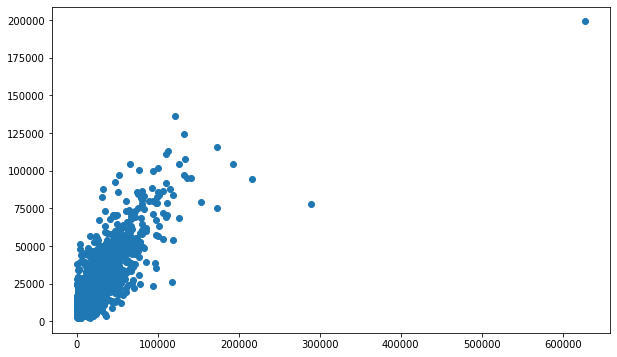

In [1011]:
plt.scatter(y_test,predictions)

# Step 7. Time for some EVALUATION!!!

In [1012]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSLE:', np.sqrt(metrics.mean_squared_log_error(y_test, predictions)))

MAE: 5490.518931237047
MSE: 136426705.71328387
RMSLE: 0.6256165178400324


**Beautiful!!** Now, let us try fitting our model with the whole dataset training dataset.

In [1013]:
# To improve accuracy, create a new RandomizedSearchCV model which you will train on all training data
rf_random_on_full_data = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_log_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)


# fit rf_random_on_full_data on all data from the training data
rf_random_on_full_data.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   6.3s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  10.2s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [1014]:
rf_random_on_full_data.best_score_

-0.39240047044428644

# Loading test.csv and making predictions

Now, for the last step, we pre-process the test dataset from test.csv using our conditions and then predict the Price using our model and append it to submission.csv.

In [1015]:
url2 = "/content/MathCo_Hackathon/test.csv"
df2 = pd.read_csv(url2)

In [1016]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8245 entries, 0 to 8244
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8245 non-null   int64  
 1   Levy              8245 non-null   object 
 2   Manufacturer      8245 non-null   object 
 3   Model             8245 non-null   object 
 4   Prod. year        8245 non-null   int64  
 5   Category          8245 non-null   object 
 6   Leather interior  8245 non-null   object 
 7   Fuel type         8245 non-null   object 
 8   Engine volume     8245 non-null   object 
 9   Mileage           8245 non-null   object 
 10  Cylinders         8245 non-null   int64  
 11  Gear box type     8245 non-null   object 
 12  Drive wheels      8245 non-null   object 
 13  Doors             8245 non-null   object 
 14  Wheel             8245 non-null   object 
 15  Color             8245 non-null   object 
 16  Airbags           8245 non-null   int64  


In [1017]:
df2.drop(['ID', 'Levy', 'Price'],axis=1, inplace=True)
df2 = df2.applymap(lambda s:s.lower() if type(s) == str else s)
df2['Mileage'] = df2.Mileage.str.split(expand=True)
df2['Mileage'] = df2['Mileage'].astype(str).astype(int)
df2[['Engine volume', 'Turbo']] = df2['Engine volume'].str.split(expand=True)
df2['Engine volume'] = df2['Engine volume'].astype(float)
df2['Cylinders'] = df2['Cylinders'].astype(int)
df2.replace(to_replace='turbo',value='1',inplace=True)
df2['Turbo'] = df2['Turbo'].fillna(0)
df2['Turbo'].astype(str).astype(int)
df2.replace(to_replace=['02-mar','04-may'],value={'2','4'},inplace=True)
df2['Current Year'] = 2021
df2['no. of years'] = df2['Current Year'] - df2['Prod. year']
df2.drop(labels=['Prod. year','Current Year'],axis=1,inplace=True)
df2_final = df2.drop(labels=['Manufacturer',	'Model'],axis=1)
df2_other_cols = df2_final.drop(columns=categorical)
df2_out = pd.concat([df2_other_cols, pd.get_dummies(df2_final[categorical])], axis=1)

df2_out.loc[df2_out['Engine volume'] > 8.4, 'Engine volume'] = df2_out['Engine volume'].median()
df2_out.loc[df2_out['Engine volume'] < 1.2, 'Engine volume'] = df2_out['Engine volume'].median()

df2_out.loc[df2_out['Mileage'] == 0, 'Mileage'] = df2_out['Mileage'].median()
df2_out.loc[df2_out['Mileage'] > 999999, 'Mileage'] = df2_out['Mileage'].median()

df2_out.loc[df2_out['Cylinders'] > 8, 'Cylinders'] = df2_out['Cylinders'].median()
df2_out.loc[df2_out['Cylinders'] < 1, 'Cylinders'] = df2_out['Cylinders'].median()

df2_out.loc[df2_out['Airbags'] > 10, 'Airbags'] = df2_out['Airbags'].median()



In [1018]:
df2_out.head()

,Engine volume,Mileage,Cylinders,Airbags,Turbo,no. of years,Category_cabriolet,Category_coupe,Category_goods wagon,Category_hatchback,Category_jeep,Category_limousine,Category_microbus,Category_minivan,Category_pickup,Category_sedan,Category_universal,Leather interior_no,Leather interior_yes,Fuel type_cng,Fuel type_diesel,Fuel type_hybrid,Fuel type_hydrogen,Fuel type_lpg,Fuel type_petrol,Fuel type_plug-in hybrid,Gear box type_automatic,Gear box type_manual,Gear box type_tiptronic,Gear box type_variator,Drive wheels_4x4,Drive wheels_front,Drive wheels_rear,Doors_2,Doors_4,Doors_>5,Wheel_left wheel,Wheel_right-hand drive,Color_beige,Color_black,Color_blue,Color_brown,Color_carnelian red,Color_golden,Color_green,Color_grey,Color_orange,Color_pink,Color_purple,Color_red,Color_silver,Color_sky blue,Color_white,Color_yellow
0,2.0,127675,4,10,1,9,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2.4,26000,4,10,0,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1.5,168000,4,8,0,16,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3.2,143000,6,6,0,9,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.6,200000,4,0,0,28,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1019]:
df2_out.shape

(8245, 54)

In [1020]:
df2_preds = rf_random_on_full_data.predict(df2_out)

In [1021]:
output = pd.DataFrame({'Price': df2_preds})
output.to_csv('/content/MathCo_Hackathon/submission.csv', index=False)

# THANK YOU!!!